In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import pandas as pd
import math

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [2]:
# Importa dados socioeconômicos dos países
df_world_soc = pd.read_csv("../databases/worldInfo_v2.csv")
df_world_soc.loc[:, "Country"] = df_world_soc.loc[:, "Country"].astype("category")

# Importa dados do COVID-19 para cada país
df_world_spread = pd.read_csv("../databases/worldCovid_v2.csv")
df_world_spread.loc[:, "Date_reported"] = pd.to_datetime(df_world_spread.loc[:, "Date_reported"], format="%Y-%m-%d")
df_world_spread.loc[:, "Country"] = df_world_spread.loc[:, "Country"].astype("category")

## Visualização da evolução da doença para os 10 países com maior número de casos cumulativos

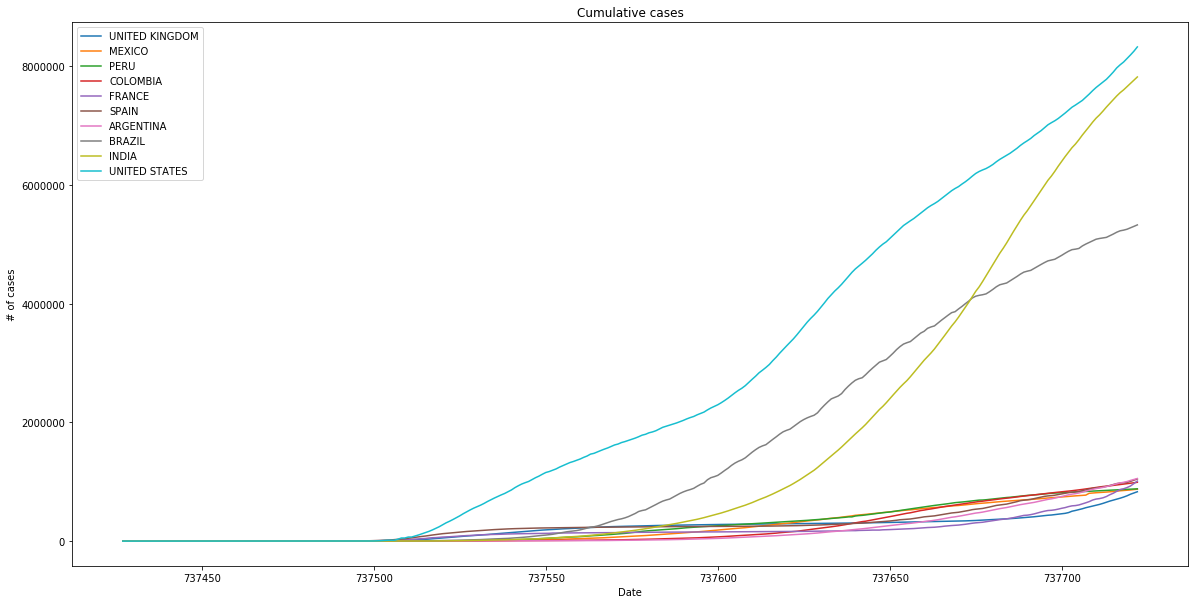

In [3]:
# Evolução da feature "Novos casos" ao longo do tempo para os países
dates = list(set(df_world_spread['Date_reported']))
dates.sort()
dates = dt.date2num(dates)

countries = df_world_spread.groupby("Country").max().sort_values("Cumulative_cases").tail(10).index

plt.figure(figsize=(20,10))
for country in countries:
    cases = df_world_spread[df_world_spread['Country'] == country]['Cumulative_cases']
    plt.plot(dates,cases.values, label = country)
    plt.title('Cumulative cases')
    plt.xlabel('Date')
    plt.ylabel('# of cases')

plt.legend()
plt.show()

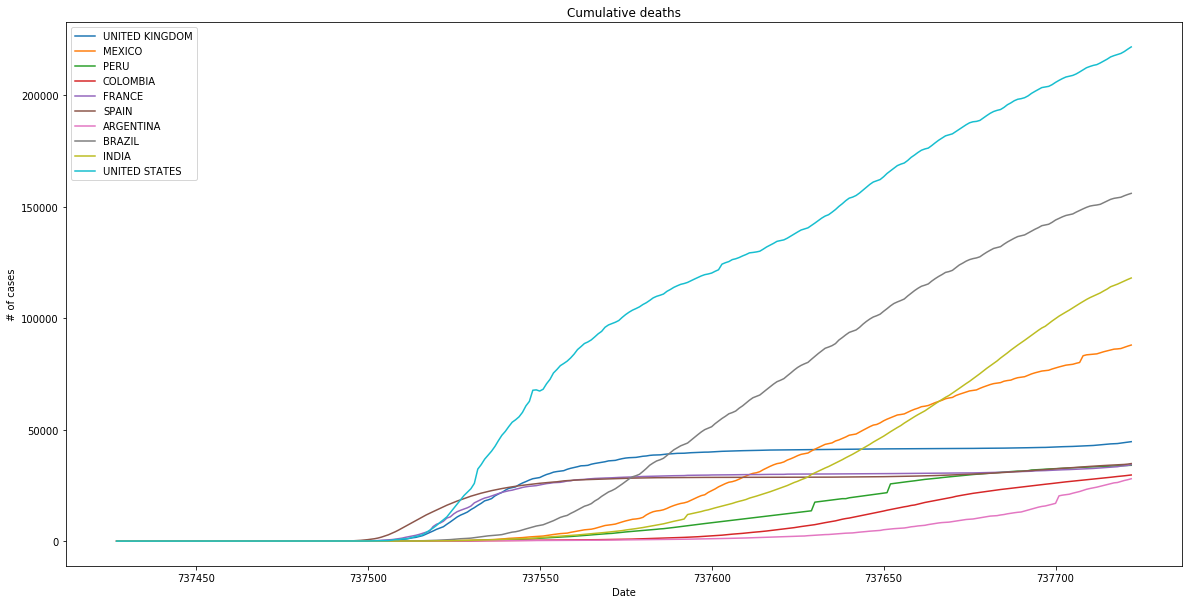

In [4]:
# Evolução da feature "Mortes cumulativas" ao longo do tempo para os países
plt.figure(figsize=(20,10))
for country in countries:
    cases = df_world_spread[df_world_spread['Country'] == country]['Cumulative_deaths']
    plt.plot(dates,cases.values, label = country)
    plt.title('Cumulative deaths')
    plt.xlabel('Date')
    plt.ylabel('# of cases')

plt.legend()
plt.show()

## Exploração dos dados mundiais

Agora juntaremos os dados socioconômicos dos países com os dados da evolução do Covid para tentar explorar a relação entre os índices socioeconômicos e a evolução da doença. Primeiro, testaremos as seguintes hipóteses utilizando testes de permutação. As decisões envolvidas na modelagem dos teste estão descritas abaixo: 

1. O IDH do país influencia o número máximo de casos totais que o país atingiu?
    - IDH foi dividido nas categorias: "alto" (1) para IDH acima de 0.759 e "baixo" (0) para IDH abaixo de 0.759;
    - A métrica utilizada ao longo das permutações é a diferença média de casos cumulativos por mil habitantes
      entre países com IDH "alto" e países com IDH "baixo".
2. O Gasto com saúde per capita do país influencia o número máximo de casos totais que o país atingiu?
    - O Gasto com saúde per capita foi dividido nas categorias "acima da mediana" (1) e "abaixo da mediana" (0);
    - A métrica utilizada ao longo das permutações é a diferença média de casos cumulativos por mil habitantes
      entre países com gasto com saúde per capita "acima da mediana" e países com gasto com saúde per capita
      "abaixo da mediana".
3. A temperatura média do país influencia o número máximo de casos totais que o país atingiu?
    - A temperatura média foi dividida nas categorias "acima da média" (1) e "abaixo da média" (0).
    - A métrica utilizada ao longo das permutações é a diferença média de casos cumulativos por mil habitantes
      entre países com gasto com temperatura média "acima da média" e países com temperatura média
      "abaixo da média".

Como a população total influencia no número máximo de casos totais de cada país, a coluna "cumulative_cases_per_thousand" foi criada dividindo a coluna "Cumulative_cases" pela coluna "pop_total" e multiplicando por 1000, representando número máximo de casos totais por mil habitantes para cada país.

In [5]:
# Criação de um dataframe contendo dados socioeconômicos e o número máximo de casos totais
# por mil habitantes para cada país
df_merge = pd.merge(df_world_spread, df_world_soc, on='Country')
df_cumulative_cases = df_merge.groupby('Country')['Cumulative_cases'].max().to_frame()
df_world_soc_cumulative_cases = pd.merge(df_world_soc, df_cumulative_cases, on=['Country'])
df_world_soc_cumulative_cases['cumulative_cases_per_thousand'] = df_world_soc_cumulative_cases['Cumulative_cases'] / df_world_soc_cumulative_cases['pop_total'] * 1000
df_world_soc_cumulative_cases

,Unnamed: 0,Country,IDH,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,chegada_turistas,gasto_saude_per_capita,acesso_agua,temp_media,area_floresta,precipitacao,Cumulative_cases,cumulative_cases_per_thousand
0,0,NORWAY,0.95,68058.62,5421241.0,15.0,40.0,0.83,5688000.0,7936.38,1.00,1.50,0.33,1414.0,17232,3.178608
1,1,SWITZERLAND,0.95,59374.73,8654622.0,219.0,43.0,0.74,10362000.0,9956.26,1.00,5.50,0.32,1537.0,103323,11.938476
2,2,IRELAND,0.94,55659.68,4937786.0,72.0,38.0,0.63,10926000.0,4976.86,0.98,9.30,0.11,1118.0,55261,11.191453
3,3,GERMANY,0.94,46945.95,83783942.0,240.0,46.0,0.76,38881000.0,5033.45,1.00,8.50,0.33,700.0,418005,4.989083
4,4,AUSTRALIA,0.94,44097.02,25499884.0,3.0,38.0,0.86,9246000.0,5331.82,1.00,21.65,0.16,534.0,27484,1.077809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,MOZAMBIQUE,0.45,1153.70,31255435.0,40.0,18.0,0.38,2743000.0,21.07,0.81,23.80,0.48,1032.0,11748,0.375871
112,112,SIERRA LEONE,0.44,1381.30,7976983.0,111.0,19.0,0.43,57000.0,66.40,0.85,26.05,0.43,2526.0,2343,0.293720
113,113,BURKINA FASO,0.43,1705.49,20903273.0,76.0,18.0,0.31,144000.0,44.40,0.98,28.25,0.19,748.0,2433,0.116393
114,114,MALI,0.43,1965.39,20250833.0,17.0,16.0,0.44,14000.0,31.38,0.96,28.25,0.04,282.0,3440,0.169870


## Teste de hipótese 1: O IDH do país influencia o número máximo de casos totais que o país atingiu?

In [6]:
def generate_permutation(filter_):
    diferencas = np.zeros(5000)
    for i in range(5000):
        np.random.shuffle(filter_)
        diferencas[i] = cases_idh[filter_]['cumulative_cases_per_thousand'].mean() - cases_idh[~filter_]['cumulative_cases_per_thousand'].mean()
    
    return diferencas

In [7]:
# Teste de permutação para IDH e Máximo de casos acumulados
# Hipótese: o IDH influencia o número total de casos por mil habitantes

cases_idh = df_world_soc_cumulative_cases[['Country', 'cumulative_cases_per_thousand', 'IDH']].copy().set_index('Country')
cases_idh['idh_score'] = 0

for country in set(df_world_soc['Country']):
    # Divisão de países por IDH:
    # Acima de 0.759 = alto
    # Abaixo de 0.759 = Baixo
    idh_score = 0
    if (cases_idh.loc[[country], :]['IDH'].values[0] >= 0.759):
        # Valor retirado de https://mundoeducacao.uol.com.br/geografia/paises-desenvolvidos.htm
        idh_score = 1
    
    cases_idh.at[country, 'idh_score'] = idh_score

In [8]:
# Diferença real das médias (IDH)
is_idh_alto = cases_idh['idh_score'] == 1
diff_real_idh = cases_idh[is_idh_alto]['cumulative_cases_per_thousand'].mean() - cases_idh[~is_idh_alto]['cumulative_cases_per_thousand'].mean()
diff_real_idh

7.319891632019598

In [9]:
diferencas = generate_permutation(is_idh_alto)

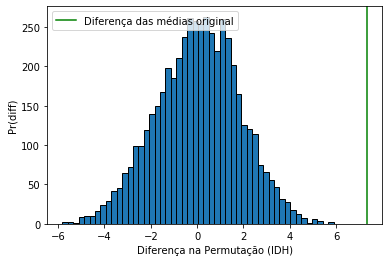

In [10]:
plt.hist(diferencas, bins=50, edgecolor='k')
plt.axvline(x=diff_real_idh, color='green', label="Diferença das médias original")
plt.xlabel('Diferença na Permutação (IDH)')
plt.ylabel('Pr(diff)')
plt.legend()
plt.show()

### Pelo teste de hipótese acima rejeitamos a hipótese nula: o IDH de cada país parece ter um impacto alto no número máximo de casos por mil habitantes

## Teste de hipótese 2: O Gasto com saúde per capita do país influencia o número máximo de casos totais que o país atingiu?

In [11]:
# Teste de permutação para Gasto com saúde per capita e Máximo de casos acumulados
# Hipótese: o Gasto com saúde per capita influencia o número total de casos por mil habitantes

mediana_gasto_saude = df_world_soc['gasto_saude_per_capita'].median()
cases_saude = df_world_soc_cumulative_cases[['Country', 'cumulative_cases_per_thousand', 'gasto_saude_per_capita']].copy().set_index('Country')
cases_saude['saude_score'] = 0

for country in set(df_world_soc['Country']):
    # Divisão de países por Gasto de saúde - acima ou abaixo da mediana
    saude_score = 0
    if (cases_saude.loc[[country], :]['gasto_saude_per_capita'].values[0] >= mediana_gasto_saude):
        saude_score = 1
    
    cases_saude.at[country, 'saude_score'] = saude_score

In [12]:
# Diferença real das médias (gasto_saude_per_capita)
is_gasto_acima_mediana = cases_saude['saude_score'] == 1
diff_real_saude = cases_saude[is_gasto_acima_mediana]['cumulative_cases_per_thousand'].mean() - cases_saude[~is_gasto_acima_mediana]['cumulative_cases_per_thousand'].mean()
diff_real_saude

7.377569543331875

In [13]:
diferencas = generate_permutation(is_gasto_acima_mediana)

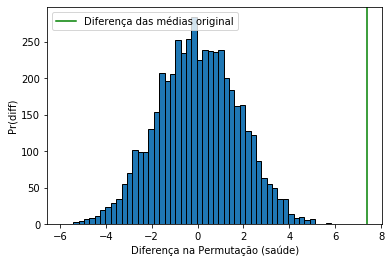

In [14]:
plt.hist(diferencas, bins=50, edgecolor='k')
plt.axvline(x=diff_real_saude, color='green', label="Diferença das médias original")
plt.xlabel('Diferença na Permutação (saúde)')
plt.ylabel('Pr(diff)')
plt.legend()
plt.show()

### Pelo teste de hipótese acima rejeitamos a hipótese nula: o gasto com saúde per capita de cada país parece ter um impacto alto no número máximo de casos por mil habitantes

## Teste de hipótese 3: A temperatura média do país influencia o número máximo de casos totais que o país atingiu?

In [15]:
# Teste de permutação para Temperatura média e Máximo de casos acumulados
# Hipótese: a temperatura média do país influencia o número total de casos por mil habitantes

media_temperatura = df_world_soc['temp_media'].mean()
cases_temp = df_world_soc_cumulative_cases[['Country', 'cumulative_cases_per_thousand', 'temp_media']].copy().set_index('Country')
cases_temp['temp_score'] = 0

for country in set(df_world_soc['Country']):
    # Divisão de países por Gasto de saúde - acima ou abaixo da média
    temp_score = 0
    if (cases_temp.loc[[country], :]['temp_media'].values[0] >= media_temperatura):
        temp_score = 1
    
    cases_temp.at[country, 'temp_score'] = temp_score

In [16]:
is_temperatura_acima_media = cases_temp['temp_score'] == 1
diff_real_temperatura = cases_temp[is_temperatura_acima_media]['cumulative_cases_per_thousand'].mean() - cases_temp[~is_temperatura_acima_media]['cumulative_cases_per_thousand'].mean()
diff_real_temperatura

-2.069523801705045

In [17]:
diferencas = generate_permutation(is_temperatura_acima_media)

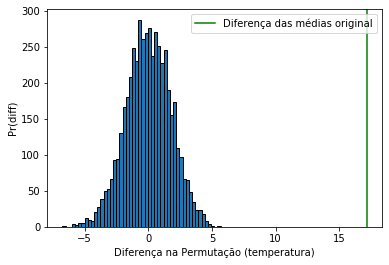

In [18]:
plt.hist(diferencas, bins=50, edgecolor='k')
plt.axvline(x=media_temperatura, color='green', label="Diferença das médias original")
plt.xlabel('Diferença na Permutação (temperatura)')
plt.ylabel('Pr(diff)')
plt.legend()
plt.show()

### Pelo teste de hipótese acima rejeitamos a hipótese nula: o gasto com saúde per capita de cada país parece ter um impacto alto no número máximo de casos por mil habitantes

## Análise da relação de IDH, Gasto com saúde per capita e temperatura com o número máximo de total de casos por país

Como podemos ver pelos testes acima, os três fatores escolhidos - IDH, gasto com saúde per capita e temperatura média - parecem estar fortemente relacionados com o número total de casos por mil habitantes. Gostaríamos então de descobrir como se dá essa relação.

Text(0.5, 1.0, 'Relação entre IDH e Casos cumulativos')

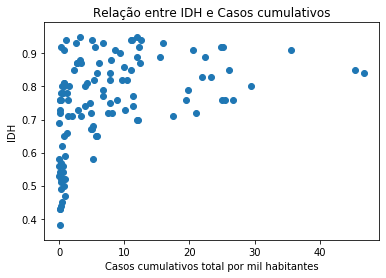

In [19]:
plt.scatter(df_world_soc_cumulative_cases['cumulative_cases_per_thousand'], df_world_soc_cumulative_cases['IDH'])
plt.xlabel('Casos cumulativos total por mil habitantes')
plt.ylabel('IDH')
plt.title('Relação entre IDH e Casos cumulativos')

Text(0.5, 1.0, 'Relação entre Gasto com saúde per capita e Casos cumulativos')

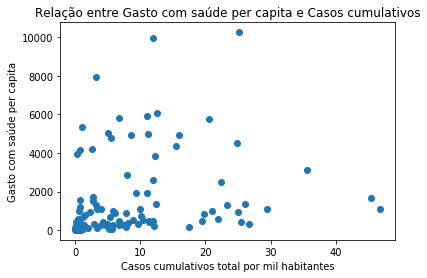

In [20]:
plt.scatter(df_world_soc_cumulative_cases['cumulative_cases_per_thousand'], df_world_soc_cumulative_cases['gasto_saude_per_capita'])
plt.xlabel('Casos cumulativos total por mil habitantes')
plt.ylabel('Gasto com saúde per capita')
plt.title('Relação entre Gasto com saúde per capita e Casos cumulativos')

Text(0.5, 1.0, 'Relação entre Temperatura Média e Casos cumulativos')

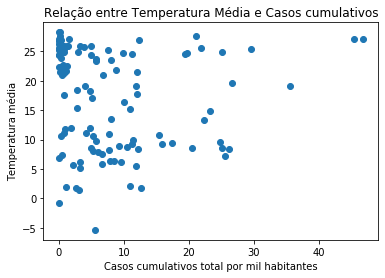

In [21]:
plt.scatter(df_world_soc_cumulative_cases['cumulative_cases_per_thousand'], df_world_soc_cumulative_cases['temp_media'])
plt.xlabel('Casos cumulativos total por mil habitantes')
plt.ylabel('Temperatura média')
plt.title('Relação entre Temperatura Média e Casos cumulativos')

Através dos _scatterplots_ podemos ver que as relações entre os atributos não é linear, e portanto precisaríamos de modelos adequados para tentar prever o número de casos cumulativos total por mil habitantes para cada atributo.